# Seattle kids: changing demographics and the implications for public schools
by Laura Minter, December 2021
## Notebook 2: modeling
This notebook assumes the [data cleaning notebook]('./1_data_cleaning.ipynb') has been succesfully run to prepare data.  

## Problem Statement:

What role does density play in the distribution of children in Seattle's Urban Centers and Villages?

What role do Urban Centers and Villages play in changing enrollments in Seattle Public Schools?

Can we model enrollment using population data alone?  Does density help us with modeling?

# Modeling approach

Target model: linear regression relating enrollment data to the child population data.

In order to model annual enrollment, yearly population estimates were obtained by interpolating between census years.  While this is certainly not an exact value for the true population it provides a reasonable estimate for years in between the decennial census data.  Population lags will be considered to account for typical delays of 5, 10 and 15 years between birth and enrollment in elementary, middle, and high school, respectively.  Alternatively, data from the American Community Survey could be used but would require aggregating census tract data to arrive at UCV-level population.  

Models to evaluate:
- Simple linear regression on child population alone
- Multiple linear regression on child population and time lagged population
- NULL model assuming enrollment is average of years reported (training data only)

Averages for the null models are computed alongside each linear regression to ensure consist definitions of training and testing data.  

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

#Linear stuff
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# read in the data
ucvkids = pd.read_csv('./data/seattle_ucv_kids_cleaned.csv')
kids = pd.read_csv('./data/seattle_kids_cleaned.csv')
pop = pd.read_csv('./data/seattle_pop_cleaned.csv')
ucvpop = pd.read_csv('./data/seattle_ucv_pop_cleaned.csv')

enrollment = pd.read_csv('./data/enrollmentdata/enrollment_cleaned.csv')

In [3]:
# starting with overall population

pop_interp = pop[['NEIGH_NAME','NEIGH_NO', 'AREA_ACRES']+[col for col in pop.columns if 'TOT_POP' in col]].copy()
pop_interp.columns = ['neighborhood','neighborhood_no','area','1990', '2000', '2010', '2020']

#ucv total population, select coumns and rename
ucv_interp = ucvpop[['NEIGH_NAME','NEIGH_NO', 'AREA_ACRES']+[col for col in pop.columns if 'TOT_POP' in col]].copy()
ucv_interp.columns = ['neighborhood','neighborhood_no','area','1990', '2000', '2010', '2020']

# kids columns already selected and renamed
kids_interp = kids.copy()
kids_interp.set_index('neighborhood')


# ucvkids need to select columns, already renamed
ucvkids_interp = ucvkids[['neighborhood','neighborhood_no','area','1990', '2000', '2010', '2020']].copy()

### Preparing time lags  

In [4]:
# interpolate using 1/10 the difference between 2020 and 2010 for each area
for i in range(1,10):
    year = 2010+i
    pop_interp[f'{year}'] = pop_interp['2010']+(pop_interp['2020']- pop_interp['2010'])*i/10
    ucv_interp[f'{year}'] = ucv_interp['2010']+(ucv_interp['2020']- ucv_interp['2010'])*i/10
    kids_interp[f'{year}'] = kids_interp['2010']+(kids_interp['2020']- kids_interp['2010'])*i/10
    ucvkids_interp[f'{year}'] = ucvkids_interp['2010']+(ucvkids_interp['2020']- ucvkids_interp['2010'])*i/10
    
    #same for 2000 to 2010
    year = 2000+i
    pop_interp[f'{year}'] = pop_interp['2000']+(pop_interp['2010']- pop_interp['2000'])*i/10
    ucv_interp[f'{year}'] = ucv_interp['2000']+(ucv_interp['2010']- ucv_interp['2000'])*i/10
    kids_interp[f'{year}'] = kids_interp['2000']+(kids_interp['2010']- kids_interp['2000'])*i/10
    ucvkids_interp[f'{year}'] = ucvkids_interp['2000']+(ucvkids_interp['2010']- ucvkids_interp['2000'])*i/10
    
    #same for 1990 to 2000
    year = 1990+i
    pop_interp[f'{year}'] = pop_interp['1990']+(pop_interp['2000']- pop_interp['1990'])*i/10
    ucv_interp[f'{year}'] = ucv_interp['1990']+(ucv_interp['2000']- ucv_interp['1990'])*i/10
    kids_interp[f'{year}'] = kids_interp['1990']+(kids_interp['2000']- kids_interp['1990'])*i/10
    ucvkids_interp[f'{year}'] = ucvkids_interp['1990']+(ucvkids_interp['2000']- ucvkids_interp['1990'])*i/10
    
    

In [5]:
# now get them into time order by breaking down in terms of year and getting required info
# we will separate by year, accumulated the desired values and put them in a dictionary
# then we can make the dictionary into a dataframe

basic_cols = ['neighborhood', 'neighborhood_no', 'area']
pop_info = [] #empty list for storing dictionary entries for df?

for year in range(1990, 2021):
    info = {}
    
    # population totals we want
    info['year'] = year
    info['total population'] = np.sum(pop_interp[f'{year}'])
    info['total ucv population'] = np.sum(ucv_interp[f'{year}'])
    info['total kid population'] = np.sum(kids_interp[f'{year}'])
    info['total ucv kid population'] = np.sum(ucvkids_interp[f'{year}'])
    
    if year >= 2010:
        # enrollment totals we want
        e = enrollment[enrollment['Year']==year].copy()
        info['total enrollment'] = e[e['School Name']=='TOTAL']['Enrollment'].values[0]
        info['middle enroll'] = np.sum(e[e['Service Area']=='Middle Schools']['Enrollment'])
        info['high schools'] = np.sum(e[e['Service Area']=='High Schools']['Enrollment'])
        leveldict = {'High Schools':'h', 'Middle Schools':'m', 'Service Schools':'s', 'Option Schools with Continuous Enrollment':'o', 'All':'a'}
        e['type'] = e['Service Area'].map(lambda x: leveldict.get(x,'e')) #if not one of the other levels, it is an elementary school
        info['elementary enroll'] = np.sum(e[e['type']=='e']['Enrollment'])

    pop_info.append(info)

# put it all into a dataframe
modeldf = pd.DataFrame(pop_info)


modeldf.tail()

,year,total population,total ucv population,total kid population,total ucv kid population,total enrollment,middle enroll,high schools,elementary enroll
26,2016,685673.0,273394.6,101509.8,24672.0,53102.0,9225.0,12702.0,29593.0
27,2017,698508.5,282122.7,102842.6,25168.5,53380.0,9433.0,13095.0,29387.0
28,2018,711344.0,290850.8,104175.4,25665.0,52931.0,9746.0,12942.0,28870.0
29,2019,724179.5,299578.9,105508.2,26161.5,53627.0,9836.0,13350.0,28957.0
30,2020,737015.0,308307.0,106841.0,26658.0,52381.0,9977.0,13695.0,27297.0


In [6]:
# add population lags according to enrollment timeframes from birth
modeldf['total kid population 5 year lag'] = modeldf['total kid population'].shift(5)
modeldf['total kid population 10 year lag'] = modeldf['total kid population'].shift(10)
modeldf['total kid population 15 year lag'] = modeldf['total kid population'].shift(15)
modeldf.dropna(inplace = True)

## Brief look at correlations in data

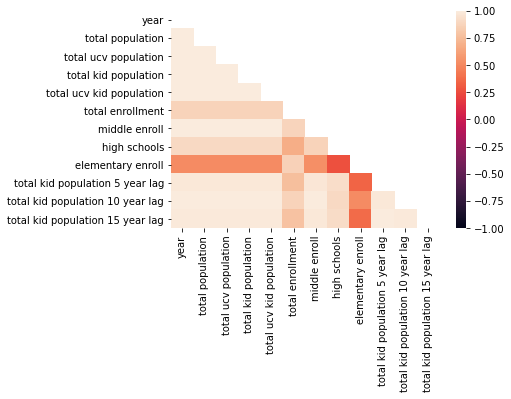

In [7]:
corr = modeldf.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, vmin = -1, vmax = 1);

Many of the features are strongly correlated.  This is unsurprising given that growth in UCVs necessarily means growth in the city.  We can trim the columns down to ensure we are not overfitting.  Starting with a model that just has the current population.

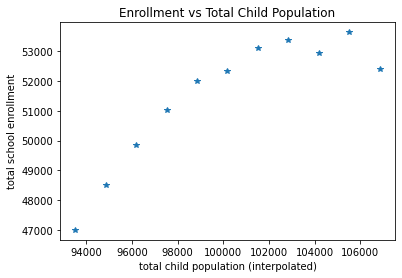

In [8]:
plt.plot(modeldf['total kid population'], modeldf['total enrollment'], '*');
plt.title('Enrollment vs Total Child Population');
plt.xlabel('total child population (interpolated)');
plt.ylabel('total school enrollment');

## Functions for scoring models

#### Note on Null Model Comparisons
The null model consists of using the average enrollment from the training set to determine the predicted enrollment.  This is sensitive to the way the data is split but should give a reasonable comparison.  The R2 score is relative to this averaged model so this is expected to be 0.  The RMSE, on the other hand, gives a sense of overall how much error there is in the model.  

In [9]:
#function to get the null model metrics given the split data
def get_null_metrics(y_train, y_test):
    # computing null model metrics
    print('Null model metrics:\n')
    print('R2 score')
    print('training     testing')
    print(round(r2_score(y_train,np.zeros_like(y_train)+ np.mean(y_train)),2), 
          '        ',round(r2_score(y_test,np.zeros_like(y_test)+ np.mean(y_train)),2))
    print()
    print('RMSE:')
    print('training     testing')


    print(round((np.sum((y_train- np.mean(y_train))**2))**0.5,2),
          '    ' ,round((np.sum((y_test- np.mean(y_test))**2))**0.5,2))

In [10]:
# function for scoring a linear regression model
def get_model_metrics(linear,X_train,X_test,y_train,y_test):
    #score with R2 and RMSE
    print('Linear model metrics:\n')
    print('R2 score:')
    print('training     testing')
    print(round(linear.score(X_train,y_train),4),'     ' ,round(linear.score(X_test,y_test),4))
    print()
    print('RMSE:')
    print('training     testing')
    print(round(mean_squared_error(y_train, linear.predict(X_train), squared = False),2),
          '     ' ,round(mean_squared_error(y_test,linear.predict(X_test), squared = False),2))
    print()


## Simple Linear Regression
Total kid population as input.  Total enrollment as output

In [11]:
# setup modeling data
X = modeldf.drop(columns = ['year','total enrollment', 'middle enroll', 'high schools', 
                            'elementary enroll', 'total population', 'total ucv population', 
                            'total ucv kid population', 'total kid population 5 year lag',
                            'total kid population 10 year lag', 'total kid population 15 year lag'])

y = modeldf['total enrollment']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [12]:
# instantiate and fit model
linear = LinearRegression()
linear.fit(X_train,y_train)

#get the coefficients
coef = dict(zip(X_train.columns,linear.coef_))

In [13]:
get_model_metrics(linear,X_train,X_test,y_train,y_test)

Linear model metrics:

R2 score:
training     testing
0.6808       0.76

RMSE:
training     testing
914.08       1402.68



In [14]:
get_null_metrics(y_train,y_test)

Null model metrics:

R2 score
training     testing
0.0          -0.05

RMSE:
training     testing
4575.76      4958.79


## Multiple Linear Regression: adding a time lag

Total kid population, total kid population 5 year lag as input.  Total enrollment as output.

In [15]:
# setup modeling data
X = modeldf.drop(columns = ['year','total enrollment', 'middle enroll', 'high schools', 
                            'elementary enroll', 'total population', 'total ucv population', 
                            'total ucv kid population', 
                            'total kid population 10 year lag', 'total kid population 15 year lag'])

y = modeldf['total enrollment']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [16]:
linear = LinearRegression()
linear.fit(X_train,y_train)
dict(zip(X_train.columns,linear.coef_))

{'total kid population': 1.6938766599865147,
 'total kid population 5 year lag': -1.8281598814718332}

In [17]:
get_model_metrics(linear,X_train,X_test,y_train,y_test)

Linear model metrics:

R2 score:
training     testing
0.9904       0.9126

RMSE:
training     testing
158.84       846.41



In [18]:
get_null_metrics(y_train,y_test)

Null model metrics:

R2 score
training     testing
0.0          -0.05

RMSE:
training     testing
4575.76      4958.79


Adding the 5 year time lag data into the fold increases the R2 from around 70% to around 91%.  This means the new models explains an extra 21 percentage points of variation in the data.  There is some overfitting with an 8-point difference between training and testing scores.  Training and testing R2 are high and we get good performance even though the model has relatively high variance.  The overall RMSE is acceptable given that the total RMSE is less than 1% of the overall enrollment, even for the testing set.  

## Looking at elementary school data

Total kid population and 5-year lag as input.  Elementary enrollment as output

In [19]:
# setup modeling data
X = modeldf.drop(columns = ['year','total enrollment', 'middle enroll', 'high schools', 
                            'elementary enroll', 'total population', 'total ucv population', 
                            'total ucv kid population', 
                            'total kid population 10 year lag', 'total kid population 15 year lag'])

y = modeldf['elementary enroll']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [20]:
linear = LinearRegression()
linear.fit(X_train,y_train)
dict(zip(X_train.columns,linear.coef_))

{'total kid population': 1.537069155556828,
 'total kid population 5 year lag': -1.9751624256517544}

In [21]:
get_model_metrics(linear,X_train,X_test,y_train,y_test)

Linear model metrics:

R2 score:
training     testing
0.9701       0.8092

RMSE:
training     testing
178.51       724.66



In [22]:
get_null_metrics(y_train,y_test)

Null model metrics:

R2 score
training     testing
0.0          -0.04

RMSE:
training     testing
2919.58      2873.41


Looking at elementary enrollment alone provides similar training R2 but a significantly lower testing R2.  That is, it appears to be overfit with a 16-point difference between training and testing R2 scores.  The total error, however, is significantly lower than the null model error and shows only minor overfitting.  

## Looking at middle school data

Total kid population and 10-year lag as input.  Middle school enrollment as output

In [23]:
# setup modeling data
X = modeldf.drop(columns = ['year','total enrollment', 'middle enroll', 'high schools', 
                            'elementary enroll', 'total population', 'total ucv population', 
                            'total ucv kid population', 'total kid population 5 year lag', 
                            'total kid population 15 year lag'])

y = modeldf['middle enroll']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [24]:
linear = LinearRegression()
linear.fit(X_train,y_train)
dict(zip(X_train.columns,linear.coef_))

{'total kid population': 680499426338.9724,
 'total kid population 10 year lag': -1595092570215.1824}

In [25]:
get_model_metrics(linear,X_train,X_test,y_train,y_test)

Linear model metrics:

R2 score:
training     testing
0.9893       0.985

RMSE:
training     testing
70.51       110.76



In [26]:
get_null_metrics(y_train,y_test)

Null model metrics:

R2 score
training     testing
0.0          -0.06

RMSE:
training     testing
1931.03      1567.64


Using a 10 year time lag on the population data is highly effective, giving an R2 of 98.5% with no evidence of overfitting.  This model shows very low RMSE, outperforming the null model on every metric.  

## Looking at high school data
Total kid population and 15-year lag as input.  Elementary enrollment as output.

Total kid population and 10-year lag as input.  Elementary enrollment as output.

In [27]:
# setup modeling data
X = modeldf.drop(columns = ['year','total enrollment', 'middle enroll', 'high schools', 
                            'elementary enroll', 'total population', 'total ucv population', 
                            'total ucv kid population', 'total kid population 5 year lag', 
                            'total kid population 10 year lag'])

y = modeldf['high schools']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [28]:
linear = LinearRegression()
linear.fit(X_train,y_train)
dict(zip(X_train.columns,linear.coef_))

{'total kid population': -0.1424926279547873,
 'total kid population 15 year lag': 0.6535589660394874}

In [29]:
get_model_metrics(linear,X_train,X_test,y_train,y_test)

Linear model metrics:

R2 score:
training     testing
0.8344       0.7246

RMSE:
training     testing
139.6       209.79



In [30]:
get_null_metrics(y_train,y_test)

Null model metrics:

R2 score
training     testing
0.0          -0.01

RMSE:
training     testing
970.18      692.42


In [31]:
# setup modeling data
X = modeldf.drop(columns = ['year','total enrollment', 'middle enroll', 'high schools', 
                            'elementary enroll', 'total population', 'total ucv population', 
                            'total ucv kid population', 'total kid population 5 year lag', 
                            'total kid population 15 year lag'])

y = modeldf['high schools']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [32]:
linear = LinearRegression()
linear.fit(X_train,y_train)
dict(zip(X_train.columns,linear.coef_))

{'total kid population': -4194781568130.8594,
 'total kid population 10 year lag': 9832579799516.21}

In [33]:
get_model_metrics(linear,X_train,X_test,y_train,y_test)

Linear model metrics:

R2 score:
training     testing
0.8121       0.9493

RMSE:
training     testing
148.7       90.0



In [34]:
get_null_metrics(y_train,y_test)

Null model metrics:

R2 score
training     testing
0.0          -0.01

RMSE:
training     testing
970.18      692.42


A 15-year lag for the high school enrollment explains about 72% of the variance but does show evidence of overfitting with an 11-point difference between training and testing of 11 point.

Using a 10-year lag results in  better performance with training R2 of 81% and testing R2 of 95%.  This still shows high variance though and is not the ideal model.  

# Model Evaluation
The time-lagged population data improved the linear models from around 69% explained variation to approximately 90% explained variation.  All of the models showed signficant improvement over the null model in terms of RMSE.  

The best model we were able to make used the population and 5-year lag of population to predict total enrollment.  This model had an R2 of 0.913 and an RMSE of 846 for unseen data.  This represents a factor of 5 decrease from the RMSE for the null model (average).  The model explains 91% of the variation in the enrollment using just two pieces of population data.  

# Next steps

Improvements to the model could include:
- adding housing data to allow longer term predictions
- breaking down to individual school level and how they compare to overall trends
